In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import (ImageDataGenerator, Iterator,
                                       array_to_img, img_to_array, load_img)
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import layers
import sys, os
import matplotlib.pyplot as plt
from sklearn import metrics
import tensorflow_model_optimization as tfmot
import shap
import keras
import matplotlib.cm as cm
from IPython.display import Image

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)
# sess.as_default()

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# for physical_device in physical_devices:
#     tf.config.experimental.set_memory_growth(physical_device, True)

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
tf.__version__

'2.3.0'

In [4]:
%matplotlib inline

In [5]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

### Data Generator

In [6]:
train_data_dir = '../data/flowers/'

img_width, img_height = 96, 96 # 224, 224
nb_train_samples = 730 
nb_validation_samples = 181
epochs = 25
batch_size = 16

if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    ) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation') # set as validation data

Found 1226 images belonging to 2 classes.
Found 305 images belonging to 2 classes.


## Model Architectures

### Custom CNN

Original model

In [8]:
# original model
# finetune_model = tf.keras.Sequential([
#     layers.InputLayer(input_shape=input_shape),
#     layers.BatchNormalization(),
#     layers.Conv2D(filters=16, kernel_size=5, padding='same', activation='elu'),
#     layers.MaxPool2D(),
    
#     layers.BatchNormalization(),
#     layers.Conv2D(32, 3, padding='same', activation='elu'),
#     layers.Conv2D(32, 3, padding='same', activation='elu'),
#     layers.MaxPool2D(),
    
#     layers.BatchNormalization(),
#     layers.Conv2D(64, 3, padding='same', activation='elu'),
#     layers.Conv2D(64, 3, padding='same', activation='elu'),
#     layers.MaxPool2D(),
    
#     layers.Flatten(),
#     layers.Dense(128, activation='elu'),
#     layers.Dropout(0.5),
#     layers.Dense(64, activation='elu'),
#     layers.Dropout(0.5),
#     layers.Dense(1, activation='sigmoid')
# ])

# finetune_model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy', 
#     metrics=['accuracy']
# )

Tiny Compatible

In [9]:
finetune_model = tf.keras.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

finetune_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr = 1e-5, decay = 1e-5),
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

### MobileNet V1

All layer trainable, imagenet initialized

In [10]:
# def build_finetune_model(base_model, dropout, fc_layers, num_classes):
#     for layer in base_model.layers:
#         layer.trainable = True #change this to False is retraining is not to be done in base layers

#     x = base_model.output
#     x = Flatten()(x)
#     for fc in fc_layers:
#         # New FC layer, random init
#         x = Dense(fc, activation='relu')(x) 
#         x = Dropout(dropout)(x)

#     # New softmax layer
#     predictions = Dense(1, activation='sigmoid')(x) 
    
#     finetune_model = Model(inputs=base_model.input, outputs=predictions)

#     return finetune_model

# base_model = MobileNet(weights='imagenet', 
#                       include_top=False, 
#                       input_shape=input_shape)

# class_list = ['CollisionOrClose', 'NoCollision']
# FC_LAYERS = [256, 256]
# dropout = 0.5

# finetune_model = build_finetune_model(base_model, 
#                                       dropout=dropout, 
#                                       fc_layers=FC_LAYERS, 
#                                       num_classes=len(class_list))

### Simple CNN

In [11]:
# finetune_model = Sequential() 
# finetune_model.add(Conv2D(32, (2, 2), input_shape = input_shape)) 
# finetune_model.add(Activation('relu')) 
# finetune_model.add(MaxPooling2D(pool_size =(2, 2))) 
  
# finetune_model.add(Conv2D(32, (2, 2))) 
# finetune_model.add(Activation('relu')) 
# finetune_model.add(MaxPooling2D(pool_size =(2, 2))) 
  
# finetune_model.add(Conv2D(64, (2, 2))) 
# finetune_model.add(Activation('relu')) 
# finetune_model.add(MaxPooling2D(pool_size =(2, 2))) 
  
# finetune_model.add(Flatten()) 
# finetune_model.add(Dense(64)) 
# finetune_model.add(Activation('relu')) 
# finetune_model.add(Dropout(0.5)) 
# finetune_model.add(Dense(1)) 
# finetune_model.add(Activation('sigmoid')) 

## Training and Testing

In [12]:
callbacks = [
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 5,
                 min_delta=0.001, restore_best_weights=True
             )
]

history = finetune_model.fit(train_generator, 
    steps_per_epoch = nb_train_samples // batch_size, 
    epochs = epochs, validation_data = validation_generator, 
    validation_steps = nb_validation_samples // batch_size, shuffle=True, callbacks = callbacks) 

Epoch 1/25
45/45 [==============================] - 4s 81ms/step - accuracy: 0.5112 - loss: 0.7863 - val_accuracy: 0.3125 - val_loss: 0.7015
Epoch 2/25
45/45 [==============================] - 3s 76ms/step - accuracy: 0.5168 - loss: 0.7583 - val_accuracy: 0.2898 - val_loss: 0.7097
Epoch 3/25
45/45 [==============================] - 3s 77ms/step - accuracy: 0.5490 - loss: 0.7133 - val_accuracy: 0.2898 - val_loss: 0.7204
Epoch 4/25
45/45 [==============================] - 3s 77ms/step - accuracy: 0.5639 - loss: 0.7025 - val_accuracy: 0.2841 - val_loss: 0.7353
Epoch 5/25
45/45 [==============================] - 3s 78ms/step - accuracy: 0.5819 - loss: 0.6709 - val_accuracy: 0.2898 - val_loss: 0.7526
Epoch 6/25
45/45 [==============================] - 3s 76ms/step - accuracy: 0.5644 - loss: 0.6888 - val_accuracy: 0.3125 - val_loss: 0.7560


### Model Summary

In [13]:
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 96, 96, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0

### Model Size

In [14]:
finetune_model.save("./my-log-dir/eurosat_model.h5")

In [15]:
import os
b = os.path.getsize("./my-log-dir/eurosat_model.h5")

print ("Model Size(mb): %d" % (b/1000000))

Model Size(mb): 15


### Performance

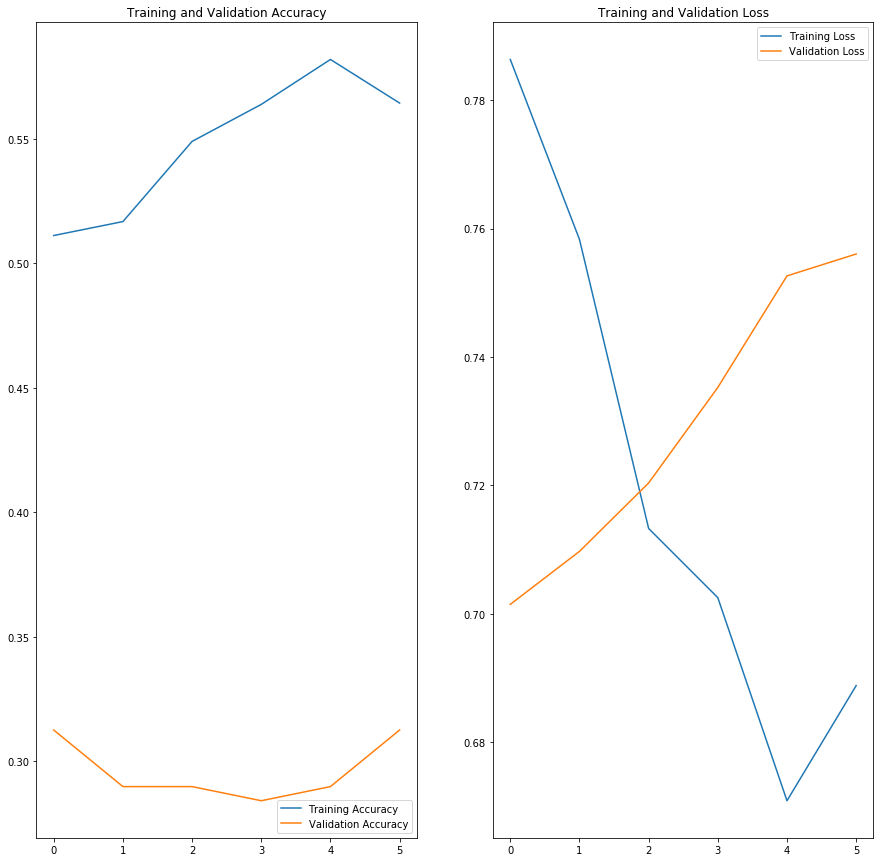

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
from keras.utils import Sequence


probabilities = finetune_model.predict_generator(generator=validation_generator)
# print(probabilities)

Instructions for updating:
Please use Model.predict, which supports generators.


In [18]:
y_true = validation_generator.classes
y_pred = probabilities > 0.5
class_labels = list(validation_generator.class_indices.keys())  

In [19]:
report = metrics.classification_report(y_true, y_pred, target_names=class_labels)
print(report)  

              precision    recall  f1-score   support

   dandelion       0.67      0.03      0.06       126
       daisy       0.59      0.99      0.74       179

    accuracy                           0.59       305
   macro avg       0.63      0.51      0.40       305
weighted avg       0.62      0.59      0.46       305



In [20]:
mat = confusion_matrix(y_true, y_pred)
print(mat)

[[  4 122]
 [  2 177]]


### Analyze Results

In [21]:
def plotImages1(images_arr, y1, y2, row_size):
    fig, axes = plt.subplots(1, row_size, figsize=(20,20))
    axes = axes.flatten()
    for img, l, p, ax in zip(images_arr, y1, y2, axes):
        ax.imshow(img)
        ax.set_title("Label:"+str(int(l))+", Pred:"+str(int(p)))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

<Figure size 1440x1440 with 0 Axes>

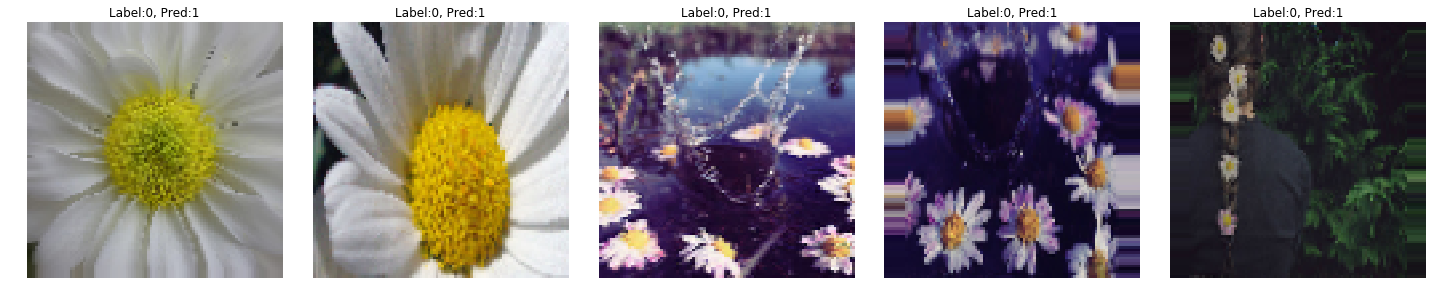

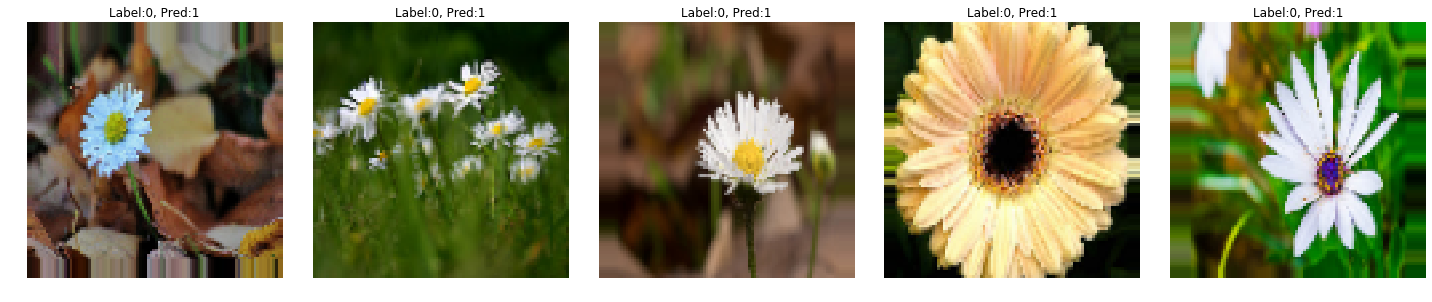

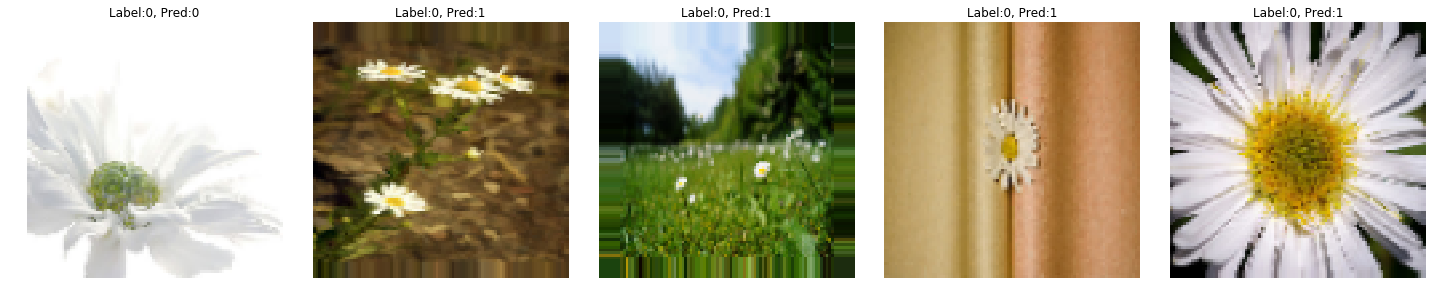

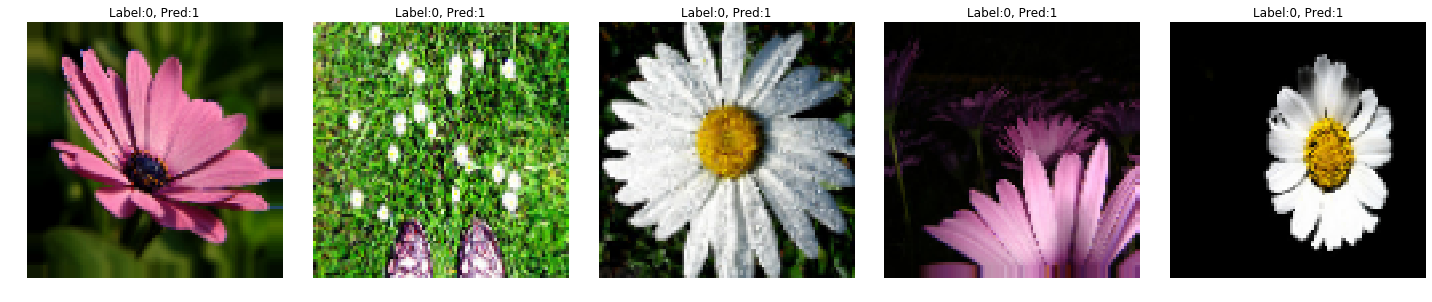

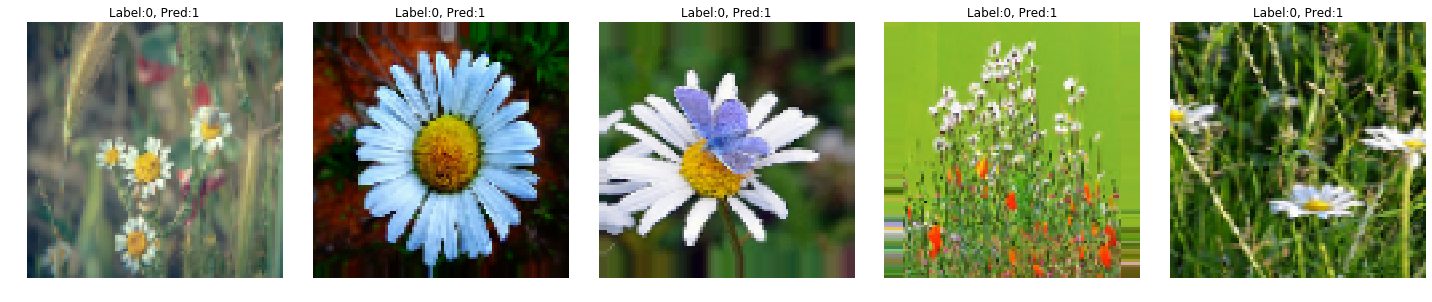

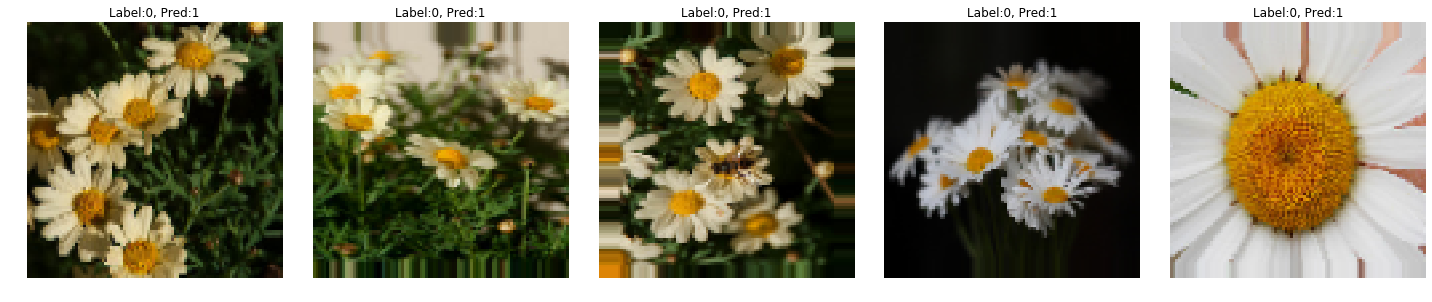

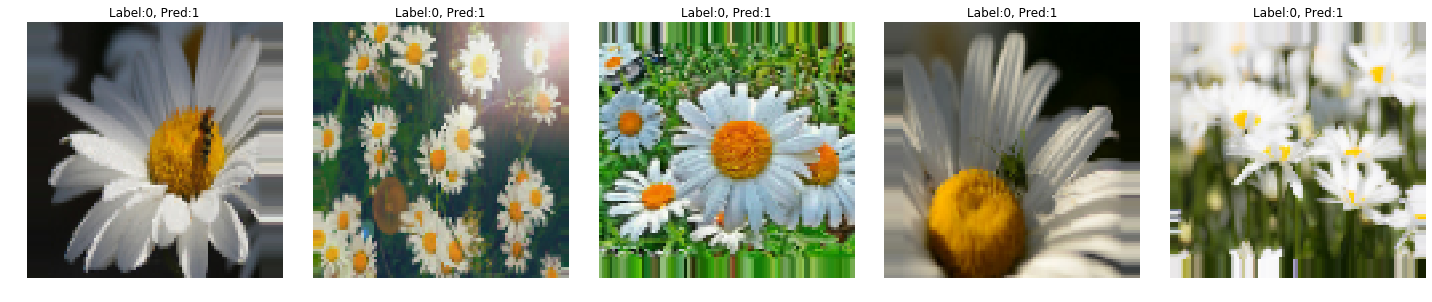

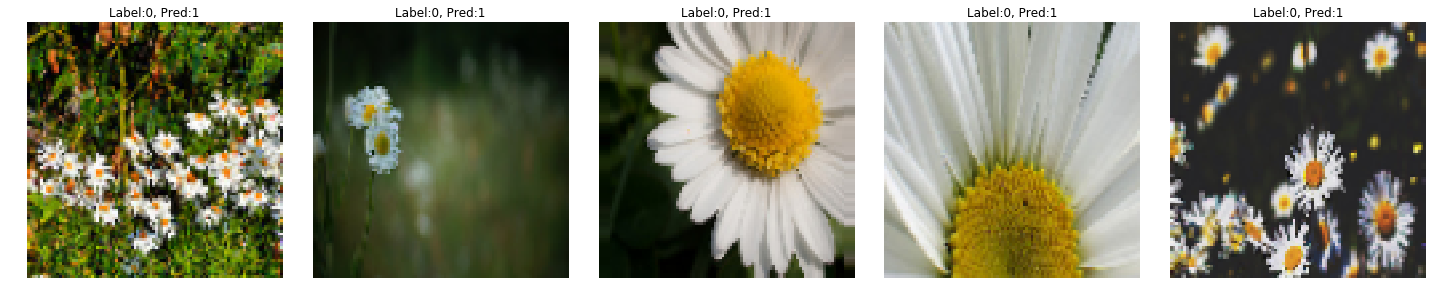

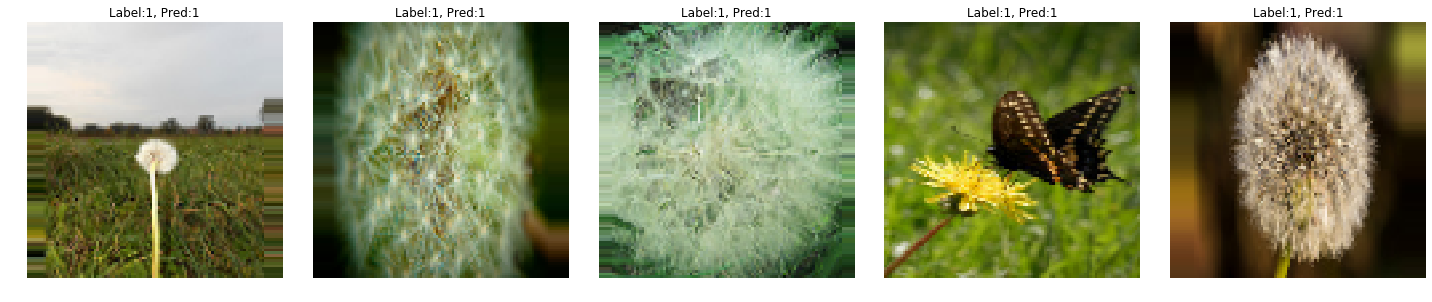

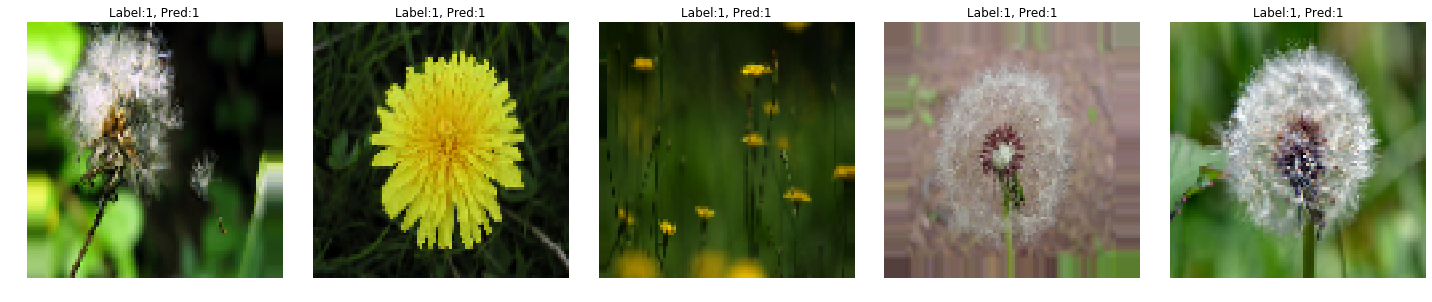

In [22]:
cnt = 0
row_size = 5
validation_generator.reset()
fig=plt.figure(figsize=(20,20))

ax = []
for i in range(10):
    x,y = next(validation_generator)
    img = x[:row_size]
    y_label = y[:row_size]
    y_predicted = y_pred[cnt:cnt+row_size]
    plotImages1(img, y_label, y_predicted, row_size)
    cnt += 16

In [23]:
labels = (validation_generator.class_indices)

In [24]:
labels

{'daisy': 0, 'dandelion': 1}

# Optimization

## Pruning

In [25]:
end_step = np.ceil(1.0 * nb_train_samples / batch_size).astype(np.int32) * epochs

pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=100)

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(finetune_model, pruning_schedule=pruning_schedule)
model_for_pruning.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_batch_no (None, 96, 96, 3)         13        
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 96, 96, 16)        2418      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 48, 48, 16)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 48, 48, 16)        65        
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 48, 48, 32)        9250      
_________________________________________________________________
prune_low_magnitude_conv2d_2 (None, 48, 48, 32)        18466     
_________________________________________________

In [26]:
logdir = './my-log-dir/'

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
  
model_for_pruning.fit(train_generator, 
    steps_per_epoch = nb_train_samples // batch_size, 
    epochs = epochs, validation_data = validation_generator, 
    validation_steps = nb_validation_samples // batch_size, shuffle=True, callbacks = callbacks)

Epoch 1/25
 1/45 [..............................] - ETA: 0s - accuracy: 0.5625 - loss: 0.7814WARNING:tensorflow:From /home/sdmohant/.virtualenvs/python3deep/lib/python3.5/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
45/45 [==============================] - 4s 87ms/step - accuracy: 0.5556 - loss: 0.7546 - val_accuracy: 0.2841 - val_loss: 0.7344
Epoch 2/25
45/45 [==============================] - 4s 79ms/step - accuracy: 0.6667 - loss: 0.5952 - val_accuracy: 0.2841 - val_loss: 0.9204
Epoch 3/25
45/45 [==============================] - 3s 77ms/step - accuracy: 0.7199 - loss: 0.5896 - val_accuracy: 0.2841 - val_loss: 0.8011
Epoch 4/25
45/45 [==============================] - 3s 77ms/step - accuracy: 0.8053 - loss: 0.4677 - val_accuracy: 0.4205 - val_loss: 0.8062
Epoch 5/25
45/45 [=============================

In [30]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(validation_generator, verbose=0)

print('Pruned test accuracy:', model_for_pruning_accuracy)


Pruned test accuracy: 0.8459016680717468


#### Export Pruned Model

In [31]:
from tensorflow_model_optimization.sparsity import keras as sparsity

final_model = sparsity.strip_pruning(model_for_pruning)
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 96, 96, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0

In [32]:
from tensorflow.keras.models import load_model
import numpy as np

# model = tf.keras.models.load_model(final_model)


for i, w in enumerate(final_model.get_weights()):
    print(
        "{} -- Total:{}, Zeros: {:.2f}%".format(
            final_model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100
        )
    )

batch_normalization/gamma:0 -- Total:3, Zeros: 0.00%
batch_normalization/beta:0 -- Total:3, Zeros: 0.00%
batch_normalization/moving_mean:0 -- Total:3, Zeros: 0.00%
batch_normalization/moving_variance:0 -- Total:3, Zeros: 0.00%
conv2d/kernel:0 -- Total:1200, Zeros: 90.00%
conv2d/bias:0 -- Total:16, Zeros: 0.00%
batch_normalization_1/gamma:0 -- Total:16, Zeros: 0.00%
batch_normalization_1/beta:0 -- Total:16, Zeros: 0.00%
batch_normalization_1/moving_mean:0 -- Total:16, Zeros: 0.00%
batch_normalization_1/moving_variance:0 -- Total:16, Zeros: 0.00%
conv2d_1/kernel:0 -- Total:4608, Zeros: 90.00%
conv2d_1/bias:0 -- Total:32, Zeros: 0.00%
conv2d_2/kernel:0 -- Total:9216, Zeros: 90.00%
conv2d_2/bias:0 -- Total:32, Zeros: 0.00%
batch_normalization_2/gamma:0 -- Total:32, Zeros: 0.00%
batch_normalization_2/beta:0 -- Total:32, Zeros: 0.00%
batch_normalization_2/moving_mean:0 -- Total:32, Zeros: 0.00%
batch_normalization_2/moving_variance:0 -- Total:32, Zeros: 0.00%
conv2d_3/kernel:0 -- Total:18432

In [33]:
import tempfile
import zipfile

# _, new_pruned_keras_file = tempfile.mkstemp(".h5")

new_pruned_keras_file = "./my-log-dir/saved_model/pruned_model.h5"
print("Saving pruned model to: ", new_pruned_keras_file)
tf.keras.models.save_model(final_model, new_pruned_keras_file, include_optimizer=False)


final_model.save('./my-log-dir/saved_model/')

# Zip the .h5 model file
_, zip3 = tempfile.mkstemp(".zip")
with zipfile.ZipFile(zip3, "w", compression=zipfile.ZIP_DEFLATED) as f:
    f.write(new_pruned_keras_file)
print(
    "Size of the pruned model before compression: %.2f Mb"
    % (os.path.getsize(new_pruned_keras_file) / float(2 ** 20))
)
print(
    "Size of the pruned model after zip compression: %.2f Mb"
    % (os.path.getsize(zip3) / float(2 ** 20))
)

Saving pruned model to:  ./my-log-dir/saved_model/pruned_model.h5
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./my-log-dir/saved_model/assets
Size of the pruned model before compression: 4.86 Mb
Size of the pruned model after zip compression: 0.88 Mb


## Quantize

#### Quantization aware training

In [34]:
LastValueQuantizer = tfmot.quantization.keras.quantizers.LastValueQuantizer
MovingAverageQuantizer = tfmot.quantization.keras.quantizers.MovingAverageQuantizer

class DefaultDenseQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    # Configure how to quantize weights.
    def get_weights_and_quantizers(self, layer):
        return [(layer.kernel, LastValueQuantizer(num_bits=4, symmetric=True, narrow_range=False, per_axis=False))]

    # Configure how to quantize activations.
    def get_activations_and_quantizers(self, layer):
        return [(layer.activation, MovingAverageQuantizer(num_bits=4, symmetric=False, narrow_range=False, per_axis=False))]

    def set_quantize_weights(self, layer, quantize_weights):
      # Add this line for each item returned in `get_weights_and_quantizers`
      # , in the same order
        layer.kernel = quantize_weights[0]

    def set_quantize_activations(self, layer, quantize_activations):
      # Add this line for each item returned in `get_activations_and_quantizers`
      # , in the same order.
        layer.activation = quantize_activations[0]

    # Configure how to quantize outputs (may be equivalent to activations).
    def get_output_quantizers(self, layer):
        return []

    def get_config(self):
        return {}


In [35]:
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
quantize_scope = tfmot.quantization.keras.quantize_scope

model_layers = [layer.name for layer in finetune_model.layers]

class ModifiedDenseQuantizeConfig(DefaultDenseQuantizeConfig):
    def get_activations_and_quantizers(self, layer):
      # Skip quantizing activations.
        return []

    def set_quantize_activations(self, layer, quantize_activations):
      # Empty since `get_activaations_and_quantizers` returns
      # an empty list.
        return
    def get_weights_and_quantizers(self, layer):
        # Configure weights to quantize with 4-bit instead of 8-bits.
        return [(layer.kernel, LastValueQuantizer(num_bits=4, symmetric=True, narrow_range=False, per_axis=False))]

 
    
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
quantize_scope = tfmot.quantization.keras.quantize_scope

class CustomLayer(tf.keras.layers.Dense):
    pass

def annotate(layer):
#     print(layer._name)
    if layer._name.startswith(model_layers[-1]):
        return tfmot.quantization.keras.quantize_annotate_layer(layer, ModifiedDenseQuantizeConfig())
    elif layer._name.startswith('batch_normalization'):
        return layer
    # quantize everything else
    else:
        return tfmot.quantization.keras.quantize_annotate_layer(layer)


annotated_model = tf.keras.models.clone_model(final_model, clone_function=annotate)

with quantize_scope({'ModifiedDenseQuantizeConfig': ModifiedDenseQuantizeConfig}):
    # Use `quantize_apply` to actually make the model quantization aware.
    quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

quant_aware_model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 96, 96, 3)         12        
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 96, 96, 16)        1251      
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 48, 48, 16)        1         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 48, 48, 32)        4707      
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 48, 48, 32)        9315      
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 24, 24, 32)        1

In [36]:
adam = Adam(lr=0.00001)
quant_aware_model.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
history = quant_aware_model.fit(train_generator, 
    steps_per_epoch = nb_train_samples // batch_size, 
    epochs = epochs, validation_data = validation_generator, 
    validation_steps = nb_validation_samples // batch_size, shuffle=True,) 

Epoch 1/25
45/45 [==============================] - 4s 83ms/step - accuracy: 0.8819 - loss: 0.3316 - val_accuracy: 0.7898 - val_loss: 0.4841
Epoch 2/25
45/45 [==============================] - 3s 74ms/step - accuracy: 0.9000 - loss: 0.2952 - val_accuracy: 0.7955 - val_loss: 0.4697
Epoch 3/25
45/45 [==============================] - 3s 77ms/step - accuracy: 0.9000 - loss: 0.2825 - val_accuracy: 0.8580 - val_loss: 0.4042
Epoch 4/25
45/45 [==============================] - 3s 75ms/step - accuracy: 0.8944 - loss: 0.2842 - val_accuracy: 0.8636 - val_loss: 0.3583
Epoch 5/25
45/45 [==============================] - 4s 78ms/step - accuracy: 0.8950 - loss: 0.2727 - val_accuracy: 0.8693 - val_loss: 0.3605
Epoch 6/25
45/45 [==============================] - 4s 78ms/step - accuracy: 0.9048 - loss: 0.2613 - val_accuracy: 0.8580 - val_loss: 0.3822
Epoch 7/25
45/45 [==============================] - 3s 77ms/step - accuracy: 0.8978 - loss: 0.2762 - val_accuracy: 0.8352 - val_loss: 0.3712
Epoch 8/25
45

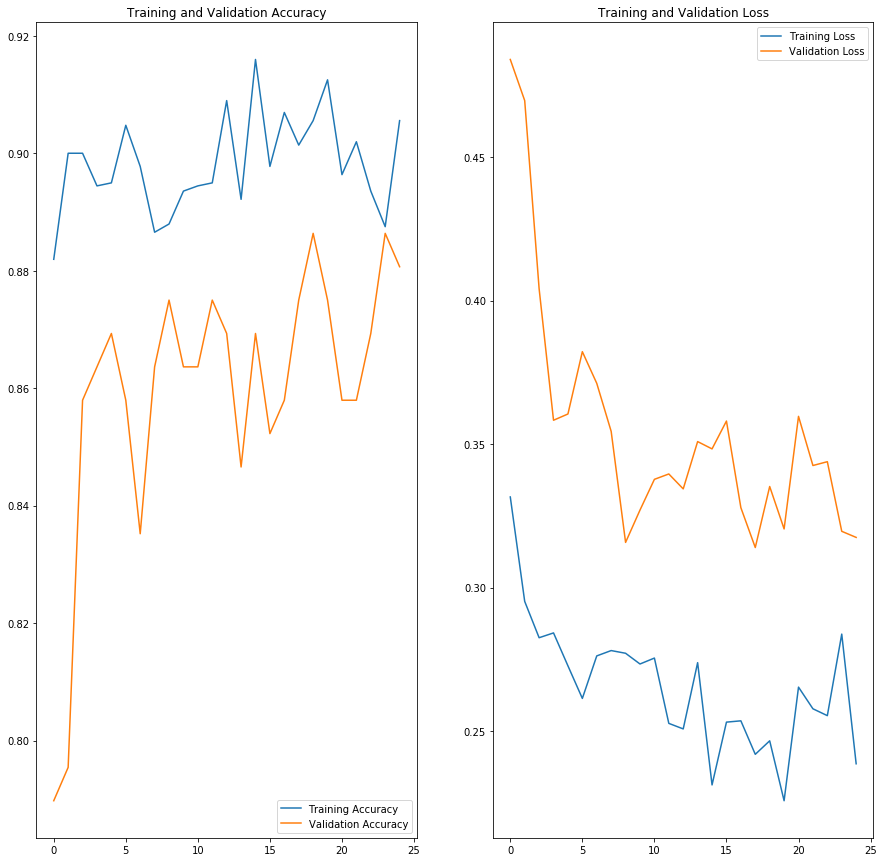

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
tflite_model_file = "./my-log-dir/saved_model/pre_quantized.tflite"

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

print(
    "Size of the quantized model before compression: %.2f Mb"
    % (os.path.getsize("./my-log-dir/saved_model/pre_quantized.tflite") / float(2 ** 20))
)

INFO:tensorflow:Assets written to: /tmp/tmpeco3u2s8/assets


ConverterError: /home/sdmohant/.virtualenvs/python3deep/lib/python3.5/site-packages/tensorflow/python/keras/layers/ops/core.py:53:0: error: 'std.constant' op requires attribute's type ('tensor<1x64xf32>') to match op's return type ('tensor<*xf32>')
/home/sdmohant/.virtualenvs/python3deep/lib/python3.5/site-packages/tensorflow/python/keras/layers/core.py:1198:0: note: called from
/home/sdmohant/.virtualenvs/python3deep/lib/python3.5/site-packages/tensorflow_model_optimization/python/core/quantization/keras/quantize_wrapper.py:162:0: note: called from
/home/sdmohant/.virtualenvs/python3deep/lib/python3.5/site-packages/tensorflow/python/autograph/impl/api.py:302:0: note: called from
/home/sdmohant/.virtualenvs/python3deep/lib/python3.5/site-packages/tensorflow/python/keras/engine/base_layer.py:985:0: note: called from
/home/sdmohant/.virtualenvs/python3deep/lib/python3.5/site-packages/tensorflow/python/keras/engine/functional.py:508:0: note: called from
/home/sdmohant/.virtualenvs/python3deep/lib/python3.5/site-packages/tensorflow/python/keras/engine/functional.py:386:0: note: called from
/home/sdmohant/.virtualenvs/python3deep/lib/python3.5/site-packages/tensorflow/python/keras/engine/sequential.py:372:0: note: called from
/home/sdmohant/.virtualenvs/python3deep/lib/python3.5/site-packages/tensorflow/python/keras/engine/base_layer.py:985:0: note: called from
/home/sdmohant/.virtualenvs/python3deep/lib/python3.5/site-packages/tensorflow/python/keras/saving/saving_utils.py:134:0: note: called from
/home/sdmohant/.virtualenvs/python3deep/lib/python3.5/site-packages/tensorflow/python/keras/layers/ops/core.py:53:0: note: see current operation: %cst_13 = "std.constant"() {value = dense<[[0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.29944551, 0.000000e+00, 0.000000e+00, 0.29944551, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.29944551, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.349353105, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, -0.349353105, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, -0.29944551, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00]]> : tensor<1x64xf32>} : () -> tensor<*xf32>


#### Post training quantization

##### Dynamic range quantization

https://www.tensorflow.org/lite/performance/post_training_quantization#dynamic_range_quantization

In [ ]:
# keras_model = tf.keras.models.load_model(new_pruned_keras_file)

# tflite_model_file = "./my-log-dir/saved_model/post_quantized.tflite"

# converter = tf.lite.TFLiteConverter.from_saved_model('./my-log-dir/saved_model/')
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# tflite_model = converter.convert()
# with open(tflite_model_file, "wb") as f:
#     f.write(tflite_model)



##### Full integer quantization. 

**Not working currently.** Maybe we have to use quantize aware training rather than post quantized training.

https://www.tensorflow.org/lite/performance/post_training_quantization#full_integer_quantization

In [ ]:
keras_model = tf.keras.models.load_model(new_pruned_keras_file)

tflite_model_file = "./my-log-dir/saved_model/post_quantized.tflite"

converter = tf.lite.TFLiteConverter.from_saved_model('./my-log-dir/saved_model/')
converter.optimizations = [tf.lite.Optimize.DEFAULT]



num_calibration_steps = 1
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        # Get sample input data as a numpy array in a method of your choosing.
        x =np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
        print(x.shape)
        yield [x]
converter.representative_dataset = representative_dataset_gen


converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

tflite_model = converter.convert()
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [ ]:
# print(
#     "Size of the quantized model before compression: %.2f Mb"
#     % (os.path.getsize("./my-log-dir/saved_model/post_quantized.tflite") / float(2 ** 20))
# )

In [ ]:
# # Zip the .h5 model file
# _, zip3 = tempfile.mkstemp(".zip")
# with zipfile.ZipFile(zip3, "w", compression=zipfile.ZIP_DEFLATED) as f:
#     f.write(tflite_model_file)
# print(
#     "Size of the pruned and quantized model before compression: %.2f Mb"
#     % (os.path.getsize(tflite_model_file) / float(2 ** 20))
# )
# print(
#     "Size of the pruned and quantized model after zip compression: %.2f Mb"
#     % (os.path.getsize(zip3) / float(2 ** 20))
# )

#### Evaluate the quantized model

In [ ]:
x=[]
y=[]
validation_generator.reset()
x=np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
y=np.concatenate([validation_generator.next()[1] for i in range(validation_generator.__len__())])
print(x.shape)
print(y.shape)

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str("./my-log-dir/saved_model/quantized.tflite"))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]


def eval_model(interpreter, x_test, y_test):
    total_seen = 0
    num_correct = 0

    for img, label in zip(x_test, y_test):
        inp = np.expand_dims(img, axis=0).astype(np.float32) 
        total_seen += 1
        interpreter.set_tensor(input_index, inp.astype('uint8')) #comment it out for float32 for dynamic quantization
        interpreter.invoke()
        
        predictions = interpreter.get_tensor(output_index)
        print(predictions)
        if predictions[0][0] > 0.5: ### needs to be changed for int quantization
            predicted = 1
        else:
            predicted = 0
        if predicted == label:
            num_correct += 1
            
        if total_seen % 1000 == 0:
            print("Accuracy after %i images: %f" %
                  (total_seen, float(num_correct) / float(total_seen)))

    return float(num_correct) / float(total_seen)

print(eval_model(interpreter, x, y))

